In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/vantuan_ngo/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import os
import glob
import scipy.io

def load_train_data(path):
    data = []
    # List all .mat files in the given path
    mat_files = glob.glob(os.path.join(path, "*.mat"))
    print(mat_files)
    for file in mat_files:
        mat_data = scipy.io.loadmat(file)
        NI_IQ = mat_data['NI_IQ'].transpose(2, 0, 1)  # Convert from (H,W,C) to (C,H,W)
        NI_IQ = NI_IQ[:2, :, :].astype(np.float32)  # Convert to float32
        if NI_IQ.shape != (2, 300, 14):
            print(f"Skipping file {file} with unexpected shape: {NI_IQ.shape}")
            continue
        if torch.isnan(torch.tensor(NI_IQ)).any() or torch.isinf(torch.tensor(NI_IQ)).any():
            print(f"Warning: Invalid values (NaN/Inf) in {file}")
            continue
        data.append(NI_IQ)
    return data

train_good_dataset = load_train_data("../datasets/FccIQ/synthetic/train/good")
print(len(train_good_dataset))
print(train_good_dataset[0].shape)

# Normalize the loaded data to [0,1] range
def normalize_data(data_list):
    # Find global min and max across all data
    all_data = np.concatenate(data_list, axis=0)
    global_min = all_data.min()
    global_max = all_data.max()
    
    print(f"Global data range: [{global_min:.6f}, {global_max:.6f}]")
    
    # Normalize each sample to [0, 1] range
    normalized_data = []
    for data in data_list:
        # Ensure data is within [0, 1] range
        normalized = np.clip((data - global_min) / (global_max - global_min + 1e-8), 0, 1)
        normalized_data.append(normalized)
    
    return normalized_data

# Normalize the training dataset
train_good_dataset = normalize_data(train_good_dataset)
print(f"Normalized dataset size: {len(train_good_dataset)}")
print(f"Sample normalized data range: [{train_good_dataset[0].min():.6f}, {train_good_dataset[0].max():.6f}]")

['../datasets/FccIQ/synthetic/train/good/MCS_24_SNR_18_NI_7_slot_7.mat', '../datasets/FccIQ/synthetic/train/good/MCS_8_SNR_38_NI_3_slot_3.mat', '../datasets/FccIQ/synthetic/train/good/MCS_22_SNR_14_NI_5_slot_10.mat', '../datasets/FccIQ/synthetic/train/good/MCS_1_SNR_8_NI_48_slot_48.mat', '../datasets/FccIQ/synthetic/train/good/MCS_8_SNR_34_NI_14_slot_14.mat', '../datasets/FccIQ/synthetic/train/good/MCS_14_SNR_8_NI_10_slot_17.mat', '../datasets/FccIQ/synthetic/train/good/MCS_2_SNR_42_NI_33_slot_33.mat', '../datasets/FccIQ/synthetic/train/good/MCS_2_SNR_34_NI_30_slot_30.mat', '../datasets/FccIQ/synthetic/train/good/MCS_8_SNR_46_NI_2_slot_2.mat', '../datasets/FccIQ/synthetic/train/good/MCS_10_SNR_38_NI_11_slot_11.mat', '../datasets/FccIQ/synthetic/train/good/MCS_1_SNR_42_NI_62_slot_62.mat', '../datasets/FccIQ/synthetic/train/good/MCS_26_SNR_34_NI_6_slot_6.mat', '../datasets/FccIQ/synthetic/train/good/MCS_1_SNR_38_NI_102_slot_102.mat', '../datasets/FccIQ/synthetic/train/good/MCS_2_SNR_6_NI

In [3]:
# Loss function
# def AE_loss(recon_x, x, mu, logvar, beta=1.0):
#     # Check for NaNs or invalid values in recon_x and x
#     if torch.isnan(recon_x).any() or torch.isnan(x).any():
#         raise ValueError("NaN detected in recon_x or x")
#     if (recon_x < 0).any() or (recon_x > 1).any():
#         raise ValueError("recon_x contains values outside [0, 1]")
#     if (x < 0).any() or (x > 1).any():
#         print(x.min())
#         print(x.max())
#         raise ValueError("x contains values outside [0, 1]")

#     # Check shapes
#     if recon_x.shape != x.shape:
#         raise ValueError(f"Shape mismatch: recon_x {recon_x.shape}, x {x.shape}")

#     # recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
#     # kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     # return recon_loss + beta * kl_loss

#     # Calculate reconstruction loss using sum of squared distances
#     recon_loss = torch.sum((recon_x - x) ** 2)
#     print(f"Recon loss: {recon_loss.item():.6f}")

#     kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     print(f"KL loss: {beta * kl_loss.item():.6f}")

#     loss = recon_loss + beta * kl_loss
#     print(f"Total loss: {loss.item():.6f}")
#     return loss

def AE_loss(recon, data, mu, logvar, beta=1.0):
    # Reconstruction loss (e.g., MSE)
    recon_loss = torch.nn.functional.mse_loss(recon, data, reduction='sum')
    # KL-divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_div

# Generate synthetic WGN images (normal data)
def generate_wgn_images(num_samples, height=28, width=28, channels=1):
    images = np.random.normal(loc=0.5, scale=0.1, size=(num_samples, channels, height, width))
    images = np.clip(images, 0, 1)
    return torch.tensor(images, dtype=torch.float32)

# Generate anomalous images (WGN + bright straight line)
def generate_anomalous_images(num_samples, height=28, width=28, channels=1):
    images = np.random.normal(loc=0.5, scale=0.1, size=(num_samples, channels, height, width))
    for i in range(num_samples):
        # Add a horizontal straight line with high brightness (e.g., value 0.9)
        line_position = np.random.randint(height // 4, 3 * height // 4)  # Random row for variety
        for c in range(channels):
            images[i, c, line_position, :] = 0.9  # Set entire row to high brightness
    images = np.clip(images, 0, 1)
    return torch.tensor(images, dtype=torch.float32)

# Training function
def train_AE(model, data_loader, epochs=20, learning_rate=1e-4, beta=1.0):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, data in enumerate(data_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = AE_loss(recon_batch, data, mu, logvar, beta)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(data_loader.dataset):.6f}")

# Anomaly detection
def detect_anomalies(model, data_loader, threshold):
    model.eval()
    anomalies = []
    recon_errors = []
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            recon, _, _ = model(data)
            recon_error = nn.functional.mse_loss(recon, data, reduction='none').mean(dim=(1,2,3))
            recon_errors.extend(recon_error.cpu().numpy())
            anomalies.extend((recon_error > threshold).cpu().numpy())
    return np.array(anomalies), np.array(recon_errors)

# Generate anomaly map
def generate_anomaly_map(original, reconstructed):
    # Convert numpy arrays to torch tensors if needed
    if isinstance(original, np.ndarray):
        original = torch.tensor(original, dtype=torch.float32)
    if isinstance(reconstructed, np.ndarray):
        reconstructed = torch.tensor(reconstructed, dtype=torch.float32)
    
    anomaly_map = (original - reconstructed) ** 2  # Use ** instead of .pow()
    anomaly_map = anomaly_map.mean(dim=1, keepdim=True)
    anomaly_map = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min() + 1e-8)
    return anomaly_map

# Visualize anomaly maps
def visualize_anomaly_maps(model, test_data, num_samples=5):
    model.eval()
    with torch.no_grad():
        sample_data = test_data[:num_samples].to(device)
        recon, _, _ = model(sample_data)
        anomaly_maps = generate_anomaly_map(sample_data, recon)
        recon_errors = nn.functional.mse_loss(recon, sample_data, reduction='none').mean(dim=(1,2,3)).cpu().numpy()

        plt.figure(figsize=(15, 4))
        for i in range(num_samples):
            # Original
            plt.subplot(3, num_samples, i + 1)
            plt.imshow(sample_data[i].cpu().squeeze(), cmap='gray')
            plt.title("Anomalous")
            plt.axis('off')
            # Reconstructed
            plt.subplot(3, num_samples, i + 1 + num_samples)
            plt.imshow(recon[i].cpu().squeeze(), cmap='gray')
            plt.title(f"Error: {recon_errors[i]:.4f}")
            plt.axis('off')
            # Anomaly Map
            plt.subplot(3, num_samples, i + 1 + 2 * num_samples)
            plt.imshow(anomaly_maps[i].cpu().squeeze(), cmap='gray')
            plt.title("Anomaly Map")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

In [4]:
import torch
import torch.nn as nn

class AE(nn.Module):
    def __init__(self, input_channels=2, latent_dim=16, img_height=300, img_width=14):
        super(AE, self).__init__()
        self.latent_dim = latent_dim
        self.img_height = img_height
        self.img_width = img_width

        # Calculate feature map size after convolutions
        def calc_feature_size(h, w):
            # First conv: kernel=(5,3), stride=(2,1), padding=(2,1)
            h = (h - 5 + 2 * 2) // 2 + 1  # Height after first conv
            w = (w - 3 + 2 * 1) // 1 + 1  # Width after first conv
            # Second conv: kernel=(5,3), stride=(2,1), padding=(2,1)
            h = (h - 5 + 2 * 2) // 2 + 1  # Height after second conv
            w = (w - 3 + 2 * 1) // 1 + 1  # Width after second conv
            return h, w

        feat_h, feat_w = calc_feature_size(img_height, img_width)
        self.feature_dim = 32 * feat_h * feat_w  # 32 filters in last conv layer

        # Debug feature map
        print(f"Calculated feature map: [32, {feat_h}, {feat_w}], feature_dim={self.feature_dim}")

        # Validate feature map size
        if feat_h <= 0 or feat_w <= 0:
            raise ValueError(f"Invalid feature map size: {feat_h}x{feat_w}")

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=(5, 3), stride=(2, 1), padding=(2, 1)),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(5, 3), stride=(2, 1), padding=(2, 1)),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.feature_dim, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, self.feature_dim)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (32, feat_h, feat_w)),
            nn.ConvTranspose2d(
                32, 16, kernel_size=(5, 3), stride=(2, 1), padding=(2, 1), output_padding=(1, 0)
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                16, input_channels, kernel_size=(5, 3), stride=(2, 1), padding=(2, 1), output_padding=(1, 0)
            ),
            nn.Sigmoid()
        )

        # Verify output size
        test_input = torch.zeros(1, input_channels, img_height, img_width)
        recon, _, _ = self.forward(test_input)
        expected_shape = (input_channels, img_height, img_width)
        if recon.shape[1:] != expected_shape:
            raise ValueError(
                f"Output shape {recon.shape[1:]} does not match expected {expected_shape}"
            )
        print(f"Output shape verified: {recon.shape[1:]}")

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [5]:
latent_dim = 16
ae = AE(input_channels=2, latent_dim=latent_dim, img_height=300, img_width=14).to(device)

Calculated feature map: [32, 75, 14], feature_dim=33600
Output shape verified: torch.Size([2, 300, 14])


In [6]:
batch_size = 512
train_loader = DataLoader(train_good_dataset, batch_size=batch_size, shuffle=True)
i, data = next(enumerate(train_loader))
print(i)
print(data.shape)

0
torch.Size([512, 2, 300, 14])


In [7]:
epochs = 200
beta = 0.5
train_AE(ae, train_loader, epochs=epochs, learning_rate=1e-4, beta=beta)

Epoch 1/200, Loss: 34.586632
Epoch 2/200, Loss: 25.512347
Epoch 3/200, Loss: 21.559829
Epoch 4/200, Loss: 20.701768
Epoch 5/200, Loss: 20.176892
Epoch 6/200, Loss: 19.786824
Epoch 7/200, Loss: 19.492573
Epoch 8/200, Loss: 19.196927
Epoch 9/200, Loss: 18.891236
Epoch 10/200, Loss: 18.620831
Epoch 11/200, Loss: 18.376564
Epoch 12/200, Loss: 18.103930
Epoch 13/200, Loss: 17.850112
Epoch 14/200, Loss: 17.596903
Epoch 15/200, Loss: 17.369631
Epoch 16/200, Loss: 17.123017
Epoch 17/200, Loss: 16.883548
Epoch 18/200, Loss: 16.663213
Epoch 19/200, Loss: 16.469480
Epoch 20/200, Loss: 16.224898
Epoch 21/200, Loss: 16.015317
Epoch 22/200, Loss: 15.826701
Epoch 23/200, Loss: 15.662255
Epoch 24/200, Loss: 15.447750
Epoch 25/200, Loss: 15.283829
Epoch 26/200, Loss: 15.124622
Epoch 27/200, Loss: 14.969422
Epoch 28/200, Loss: 14.810826
Epoch 29/200, Loss: 14.665523
Epoch 30/200, Loss: 14.529629
Epoch 31/200, Loss: 14.401215
Epoch 32/200, Loss: 14.275357
Epoch 33/200, Loss: 14.164534
Epoch 34/200, Loss:

In [8]:
import scipy.io
import numpy as np
import torch
import matplotlib.pyplot as plt

def test_AE(path):
    test_data = scipy.io.loadmat(path)
    # Extract the IQ data
    iq_data = test_data['NI_IQ']  # Assuming the key is 'data', adjust if different
    print(f"Test data shape: {iq_data.shape}")

    iq_data = iq_data.transpose(2, 0, 1)  # Convert from (H,W,C) to (C,H,W)
    iq_data = iq_data[:2, :, :].astype(np.float32)  # Convert to float32
    iq_data = (iq_data - (-3)) / 6
    print(f"Normalized data shape: {iq_data.shape}")

    # Convert to tensor and add batch dimension
    test_tensor = torch.tensor(iq_data, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    print(f"Tensor shape: {test_tensor.shape}")

    # Move to device
    test_tensor = test_tensor.to(device)

    # Encode the test sample
    with torch.no_grad():
        recon, mu, logvar = ae(test_tensor)  # Get all outputs from AE
        # z = ae.reparameterize(mu, logvar)

    # Calculate reconstruction error
    import torch.nn.functional as F
    mse_loss = F.mse_loss(recon, test_tensor)
    print(f"Reconstruction MSE: {mse_loss.item():.6f}")

    print(f"Original shape: {test_tensor.shape}")
    print(f"Reconstructed shape: {recon.shape}")
    # print(f"Latent representation shape: {z.shape}")

    print(f"Recon min: {recon.min().item():.6f}")
    print(f"Recon max: {recon.max().item():.6f}")
    # print(z)

    # # Save test_tensor and recon to text files
    # np.savetxt('test_tensor.txt', test_tensor.cpu().numpy().flatten(), fmt='%.6f')
    # np.savetxt('recon.txt', recon.cpu().numpy().flatten(), fmt='%.6f')
    
    # # Also save the shapes for reference
    # with open('shapes.txt', 'w') as f:
    #     f.write(f"test_tensor shape: {test_tensor.shape}\n")
    #     f.write(f"recon shape: {recon.shape}\n")
    #     f.write(f"test_tensor flattened size: {test_tensor.cpu().numpy().flatten().shape}\n")
    #     f.write(f"recon flattened size: {recon.cpu().numpy().flatten().shape}\n")
    # # Visualize the original vs reconstructed
    # plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(test_tensor.cpu().numpy()[0, 0], cmap='viridis')
    plt.title('Original Signal')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(recon.cpu().numpy()[0, 0], cmap='viridis')
    plt.title('Reconstructed Signal')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.colorbar()

    anomaly_map = generate_anomaly_map(test_tensor, recon)
    print(anomaly_map.shape)
    plt.subplot(1, 3, 3)
    plt.imshow(anomaly_map.cpu().numpy()[0, 0], cmap='viridis')
    plt.title('Anomaly Map')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

Test data shape: (300, 14, 3)
Normalized data shape: (2, 300, 14)
Tensor shape: torch.Size([1, 2, 300, 14])
Reconstruction MSE: 0.000004
Original shape: torch.Size([1, 2, 300, 14])
Reconstructed shape: torch.Size([1, 2, 300, 14])
Recon min: 0.495839
Recon max: 0.500048
torch.Size([1, 1, 300, 14])


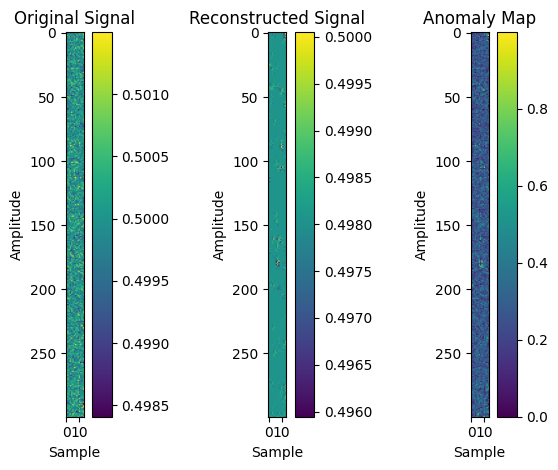

In [9]:
# Load and visualize a test sample
test_file_path = "/home/vantuan_ngo/anomalib-example/datasets/FccIQ/synthetic/train/good/MCS_28_SNR_50_NI_2_slot_2.mat"
test_AE(test_file_path)

Test data shape: (300, 14, 3)
Normalized data shape: (2, 300, 14)
Tensor shape: torch.Size([1, 2, 300, 14])
Reconstruction MSE: 0.001513
Original shape: torch.Size([1, 2, 300, 14])
Reconstructed shape: torch.Size([1, 2, 300, 14])
Recon min: 0.494592
Recon max: 0.502008
torch.Size([1, 1, 300, 14])


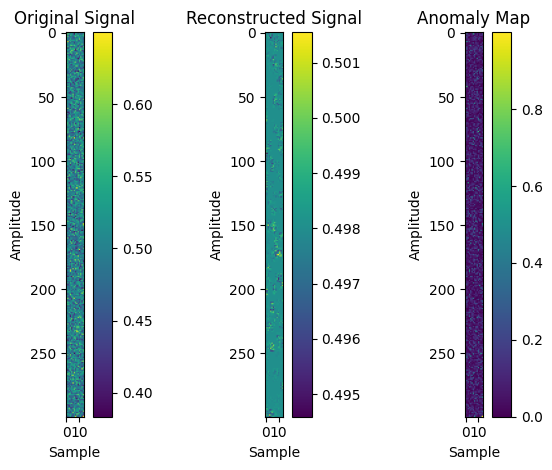

In [10]:
# Load and visualize a test sample
test_file_path = "/home/vantuan_ngo/anomalib-example/datasets/FccIQ/synthetic/train/good/MCS_28_SNR_10_NI_5_slot_15.mat"
test_AE(test_file_path)

Test data shape: (300, 14, 3)
Normalized data shape: (2, 300, 14)
Tensor shape: torch.Size([1, 2, 300, 14])
Reconstruction MSE: 0.000266
Original shape: torch.Size([1, 2, 300, 14])
Reconstructed shape: torch.Size([1, 2, 300, 14])
Recon min: 0.496235
Recon max: 0.499989
torch.Size([1, 1, 300, 14])


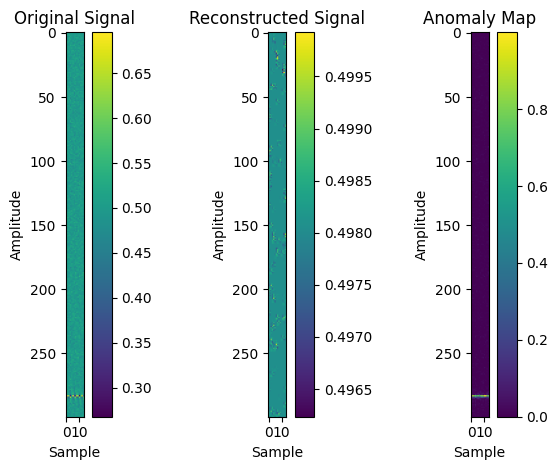

In [11]:
# Load and visualize a test sample
test_file_path = "/home/vantuan_ngo/anomalib-example/datasets/FccIQ/synthetic/test/single_tone/100.mat"
test_AE(test_file_path)

Test data shape: (300, 14, 3)
Normalized data shape: (2, 300, 14)
Tensor shape: torch.Size([1, 2, 300, 14])
Reconstruction MSE: 0.000004
Original shape: torch.Size([1, 2, 300, 14])
Reconstructed shape: torch.Size([1, 2, 300, 14])
Recon min: 0.496435
Recon max: 0.499699
torch.Size([1, 1, 300, 14])


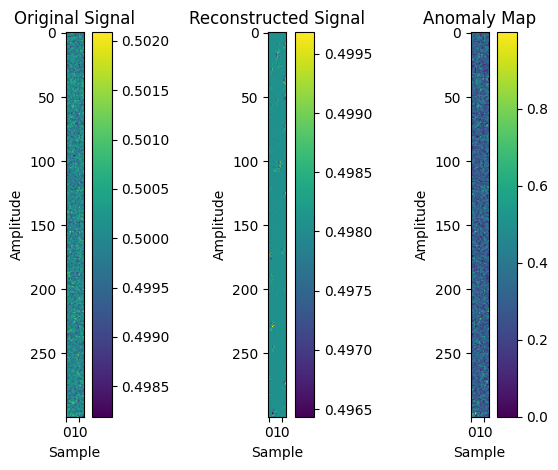

In [12]:
# Load and visualize a test sample
test_file_path = "/home/vantuan_ngo/anomalib-example/datasets/FccIQ/synthetic/train/good/MCS_28_SNR_50_NI_4_slot_4.mat"
test_AE(test_file_path)